# Clustering, cluster visualization and clustering evaluation

Outline of this notebook: Do K-means, G-MM and DBSCAN clustering on the latent space, obtain the clustering assignments, then do PCA on the latent space values and plot them according to their clustering assignment. Reports and basic accuracy metric that assumes the clustering is mostly correct, and just counts the small differences from the true labels. Uses the homework 3 data as dummy data, and takes the HMM labels from the assignment as being the true labels. Note that we get graphs that look just like the assignment, but it's missleading because we actually do PCA on the data first and PCA on a 2d space just rotates it, so for 10 dimensional space this will probably be a bit messy, but the accuracy metric will still work.

In [1]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

np.random.seed(42)

In [2]:
X = np.loadtxt("hwk3data/EMGaussian.train")
y = np.loadtxt("hwk3data/HMMlabels.train")
k = 4

In [3]:
def accuracy(test_labels, pred_labels):
    """A simple accuracy metric, makes a confusion matrix and takes then 
    maximum column-wise value as being the "correct" prediction (assumes
    that the clusters are at least close to right).
    """
    matrix = np.zeros((k,k))
    for (test, pred) in zip(test_labels, pred_labels):
        matrix[int(test)][int(pred)] += 1
    
    maxes = np.amax(matrix, axis=1)
    return np.sum(maxes)/np.sum(matrix)

In [4]:
def plot_clustering(X, labels, legend=False):
    for label in np.unique(labels):
        plt.scatter(X[labels == label][:,0], X[labels == label][:,1], s=10, alpha=0.5)
    
    if legend:
        plt.legend(np.unique(labels))
    
    plt.show()

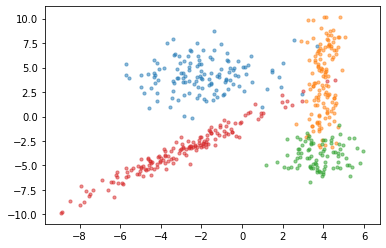

In [5]:
plot_clustering(X, y)

# K-Means

0.85


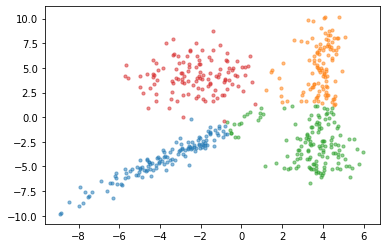

In [6]:
kmeans = KMeans(n_clusters=k,
                init='k-means++',
                n_init=200,
                max_iter=300)

kmeans.fit(X)
# centroids = kmeans.cluster_centers_
# print(centroids)

km_labels = kmeans.predict(X)
print(accuracy(y, km_labels))
plot_clustering(X, km_labels)

# Gaussian Mixture Model

0.962


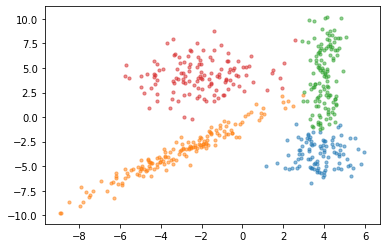

In [7]:
gmm = GaussianMixture(n_components=k,
                      covariance_type='full',
                      max_iter=100,
                      n_init=10,
                      init_params='kmeans')
gmm.fit(X)
# print(gmm.means_)
# print(gmm.covariances_)

gmm_labels = gmm.predict(X)
print(accuracy(y, gmm_labels))
plot_clustering(X, gmm_labels)

# DBSCAN
The metric must be chosen from
* scipy metrics: `[‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]` (does not sparse matrix inputs)
* scikit-learn metrics: `[‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]` (supports sparse matrix inputs) or `[‘nan_euclidean’]` (does not sparse matrix inputs)

Some notes on DBSCAN
* The algorithm is quite sensitive to the metric and min_sample parameters

[-1  0  1  2  3]


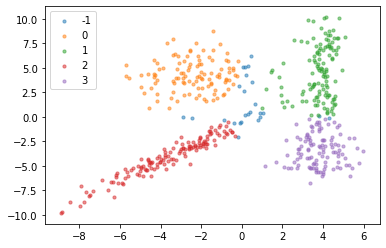

In [8]:
dbsc = DBSCAN(eps=0.5,
              min_samples=10,
              metric='canberra',
              n_jobs=-1)
dbsc_labels = dbsc.fit_predict(X)
print(np.unique(dbsc_labels))
plot_clustering(X, dbsc_labels, legend=True)

# OPTICS
OPTICS is supposed to perform about as well as DBSCAN. OPTICS is quite a bit slower than DBSCAN however.

From [scikit-learn's documentation](https://scikit-learn.org/stable/modules/clustering.html#optics):
> The results from OPTICS cluster_optics_dbscan method and DBSCAN are very similar, but not always identical; specifically, labeling of periphery and noise points. This is in part because the first samples of each dense area processed by OPTICS have a large reachability value while being close to other points in their area, and will thus sometimes be marked as noise rather than periphery. This affects adjacent points when they are considered as candidates for being marked as either periphery or noise.
>
> Note that for any single value of eps, DBSCAN will tend to have a shorter run time than OPTICS; however, for repeated runs at varying eps values, a single run of OPTICS may require less cumulative runtime than DBSCAN. It is also important to note that OPTICS’ output is close to DBSCAN’s only if eps and max_eps are close.


[-1  0  1  2  3]


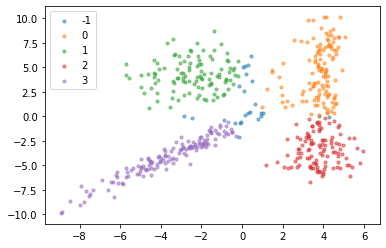

In [9]:
optics = OPTICS(min_samples=10,
                eps=0.5,
                metric='canberra',
                cluster_method='dbscan',
                n_jobs=-1)
optics_labels = optics.fit_predict(X)
print(np.unique(optics_labels))
plot_clustering(X, optics_labels, legend=True)

# PCA
PCA is not super useful for this dataset as we are already in 2D space. We only rotate to maximize variance on the pricipal axes.

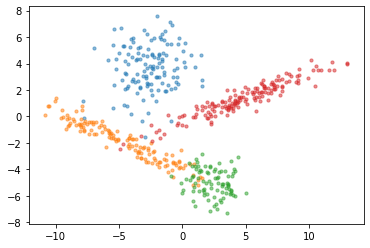

In [10]:
pca = PCA(2)
X_pca = pca.fit_transform(X=X)
plot_clustering(X_pca, y)  # Using true labels

# With new higher-dimensional data

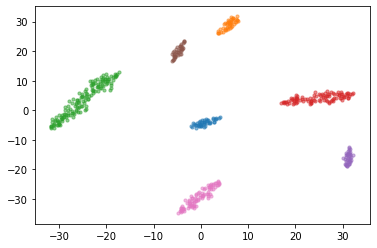

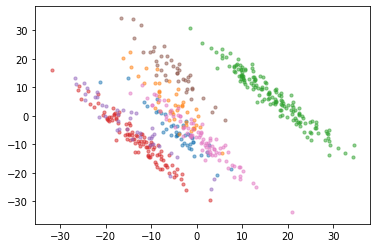

In [11]:
k = 7    # Number of clusters
d = 10   # Number dimensions
N = 500  # Number of points

pi = np.random.normal(0, 1, k)
pi = np.exp(pi) / np.sum(np.exp(pi))  # Probability of being in any cluster
y = np.random.choice(k, size=N, p=pi)
mus = np.random.uniform(-10, 10, size=(k, d))
sigmas = np.random.uniform(0, 2, size=(k, d, d))
for j in range(k):
    sigmas[j] = (sigmas[j] @ sigmas[j].T)  # Make sure sigmas are psd

X = np.zeros((N, d))
# plot_clustering(mus, np.arange(k))
for i, j in enumerate(y):
    X[i] = np.random.multivariate_normal(mus[j], sigmas[j])

plot_clustering(TSNE(n_components=2).fit_transform(X), y)
plot_clustering(pca.fit_transform(X), y)

t-SNE is much better than PCA for embedding the data in 2D for visualization - as we would expect.

1.0


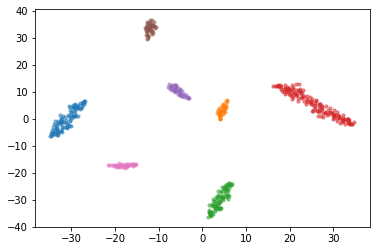

In [12]:
gmm = GaussianMixture(n_components=k,
                      covariance_type='full',
                      max_iter=100,
                      n_init=10,
                      init_params='kmeans')
gmm.fit(X)

gmm_labels = gmm.predict(X)
print(accuracy(y, gmm_labels))
plot_clustering(TSNE(n_components=2).fit_transform(X), gmm_labels)